<a href="https://colab.research.google.com/github/canmike/lulc_semantic_segmentation/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Downloading .py Files

In [1]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("utils.py").is_file():
  print("utils.py already exists, skipping download")
else:
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/canmike/lulc_semantic_segmentation/main/utils.py")
  with open("utils.py", "wb") as f:
    f.write(request.content)
  print("Downloaded utils.py.")

Downloaded utils.py.


# 2. Downloading Data

In [2]:
import gdown

id = "1WkN9LN_j0lfslSX0qC0Jlgf9bnluGSEu"
gdown.download_folder(id=id, quiet=True, use_cookies=False)
import zipfile
from pathlib import Path
import os

data_path = Path("WHISPER/")
image_path = Path("data")

with zipfile.ZipFile(data_path / "C2Seg_AB.zip", "r") as zip_ref:
    print("Unzipping C2Seg_AB data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "C2Seg_AB.zip")

Unzipping C2Seg_AB data...


# 3. Setting Models

In [3]:
import torch
import torchvision
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

In [4]:
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import (
                                             DeepLabV3_ResNet50_Weights,
                                             DeepLabV3_ResNet101_Weights,
                                             DeepLabV3_MobileNet_V3_Large_Weights
                                             )

In [5]:
import torchvision
import torch
from torchvision.models.segmentation.fcn import FCNHead

def get_model(model_name: str, channels: int=26, output_size:int= 14):
  if model_name.lower() not in ("resnet_50"):
    raise ValueError("'model_name' should be one of ('resnet_50')")

  if model_name == "resnet_50":
    model, transform = load_model(model_name)
    for param in model.parameters():
      param.requires_grad = False

    model.backbone.conv1 = torch.nn.Conv2d(channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.aux_classifier = FCNHead(in_channels=1024, channels=output_size)
    model.classifier[4] = torch.nn.Conv2d(256, output_size, kernel_size=(1, 1), stride=(1, 1))
    return model, transform

In [6]:
def load_model(model_name: str):
    if model_name.lower() not in ("mobilenet", "resnet_50", "resnet_101"):
        raise ValueError("'model_name' should be one of ('mobilenet', 'resnet_50', 'resnet_101')")

    if model_name == "resnet_50":
        model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    elif model_name == "resnet_101":
        model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    else:
        model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
        transforms = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    model.eval()

    # Warmup run

    _ = model(torch.randn(1, 3, 520, 520))

    return model, transforms

In [7]:
model_resnet_50, transforms = get_model('resnet_50', 26, 14)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 219MB/s]


In [8]:
!pip install torchinfo

In [9]:
from torchinfo import summary
summary(model=model_resnet_50,
        input_size=(1, 26, 693, 520), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
DeepLabV3 (DeepLabV3)                              [1, 26, 693, 520]    [1, 14, 693, 520]    --                   Partial
├─IntermediateLayerGetter (backbone)               [1, 26, 693, 520]    [1, 2048, 87, 65]    --                   Partial
│    └─Conv2d (conv1)                              [1, 26, 693, 520]    [1, 64, 347, 260]    81,536               True
│    └─BatchNorm2d (bn1)                           [1, 64, 347, 260]    [1, 64, 347, 260]    (128)                False
│    └─ReLU (relu)                                 [1, 64, 347, 260]    [1, 64, 347, 260]    --                   --
│    └─MaxPool2d (maxpool)                         [1, 64, 347, 260]    [1, 64, 174, 130]    --                   --
│    └─Sequential (layer1)                         [1, 64, 174, 130]    [1, 256, 174, 130]   --                   False
│    │    └─Bottleneck (0)             

# 3. Making Predictions With Untrained Model

## 3.1 Setting up device agnostic code

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 3.2 Defining color-labels and visiualization functions

In [11]:
label_map = np.array([
      (0, 0, 0),          # 0 - Background (Black)
      (0, 0, 255),        # 1 - Surface water (Blue)
      (135, 206, 250),    # 2 - Street (Light Sky Blue)
      (255, 255, 0),      # 3 - Urban Fabric (Yellow)
      (128, 0, 0),        # 4 - Industrial, commercial and transport (Maroon)
      (139, 37, 0),       # 5 - Mine, dump, and construction sites (Reddish Brown)
      (0, 128, 0),        # 6 - Artificial, vegetated areas (Green)
      (255, 165, 0),      # 7 - Arable Land (Orange)
      (0, 255, 0),        # 8 - Permanent Crops (Lime Green)
      (154, 205, 50),     # 9 - Pastures (Yellow Green)
      (34, 139, 34),      # 10 - Forests (Forest Green)
      (139, 69, 19),      # 11 - Shrub (Saddle Brown)
      (245, 245, 220),    # 12 - Open spaces with no vegetation (Beige)
      (0, 255, 255),      # 13 - Inland wetlands (Cyan)
  ])


labels = [
    "Background", "Surface water", "Street", "Urban Fabric", "Industrial, commercial and transport",
    "Mine, dump, and construction sites", "Artificial, vegetated areas", "Arable Land",
    "Permanent Crops", "Pastures", "Forests", "Shrub", "Open spaces with no vegetation", "Inland wetlands"
]

In [12]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()

    # Create 3 Numpy arrays containing zeros.
    # Later each pixel will be filled with respective red, green, and blue pixels
    # depending on the predicted class.

    red_map   = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map  = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(label_map)):
        index = labels == label_num

        R, G, B = label_map[label_num]

        red_map[index]   = R
        green_map[index] = G
        blue_map[index]  = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map


def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta  = 0.8  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum

    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)

    return image

In [13]:
from utils import get_img

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def predict_and_show(model, index):
  X, mask = get_img(index)
  with torch.inference_mode():
    output = model(X)["out"].cpu()

  W, H = output.shape[2], output.shape[3]

  # Get RGB segmentation map
  segmented_image = draw_segmentation_map(output)

  # Resize to original image size
  segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)
  #overlayed_image = image_overlay(img_raw, segmented_image)

  # Plot
  plt.figure(figsize=(20, 20))

  plt.subplot(1, 3, 1)
  # Create a custom colormap using the colors defined above
  cmap = ListedColormap(label_map / 255.0)

  # Display the mask using the custom colormap
  plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)

  plt.title("Ground Truth")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.title("Segmentation")
  plt.axis("off")
  plt.imshow(segmented_image)

  plt.show()
  plt.close()
  # Save Segmented and overlayed images
  if False:
      cv2.imwrite(seg_map_save_dir, segmented_image[:, :, ::-1])
      cv2.imwrite(overlayed_save_dir, overlayed_image)

## 3.3 Making predictions with untraind model

In [14]:
index = 111

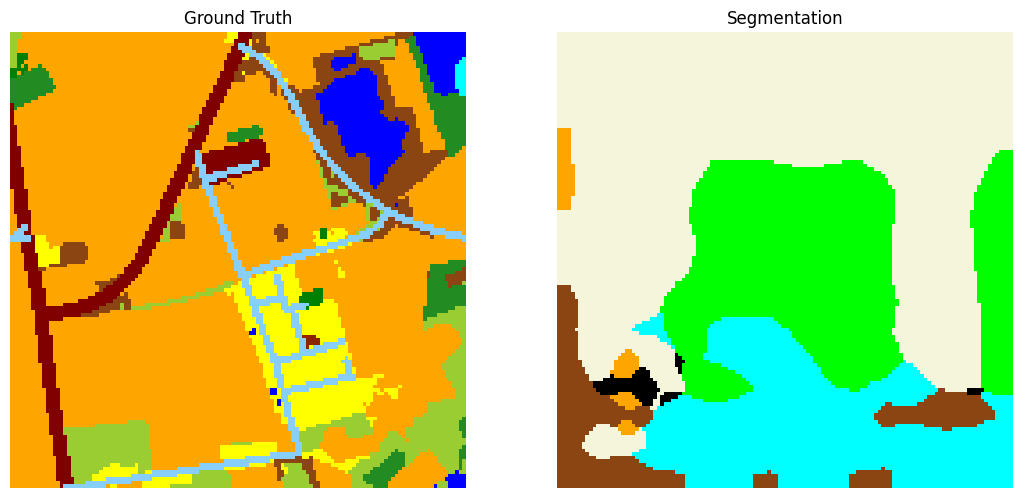

In [15]:
predict_and_show(model_resnet_50, index)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def show_mask(mask):
  # Assuming you have your mask data in a NumPy array named "mask"
  # It should be a 128x128 image containing label values from 0 to 13.

  # Create a custom colormap using the colors defined above
  cmap = ListedColormap(label_map / 255.0)

  # Display the mask using the custom colormap
  plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)

  # Set the number of unique labels for the colorbar
  num_labels = len(label_map)

  # Set the tick positions and labels for the colorbar
  ticks = np.arange(num_labels)

  # Create the colorbar with the custom labels
  cbar = plt.colorbar(ticks=ticks)
  cbar.ax.set_yticklabels(labels, fontsize=8)
  plt.axis("off")
  # Show the plot
  plt.show()

In [17]:
X, mask = get_img(index)
with torch.inference_mode():
  output = model_resnet_50(X)["out"].cpu()
W, H = output.shape[2], output.shape[3]
# Get RGB segmentation map
segmented_image = draw_segmentation_map(output)

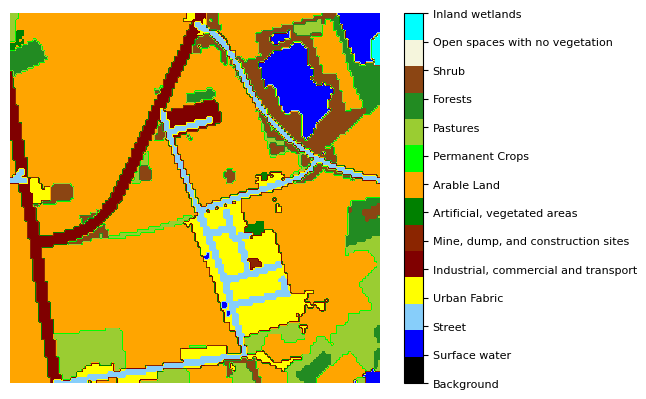

In [18]:
show_mask(mask)

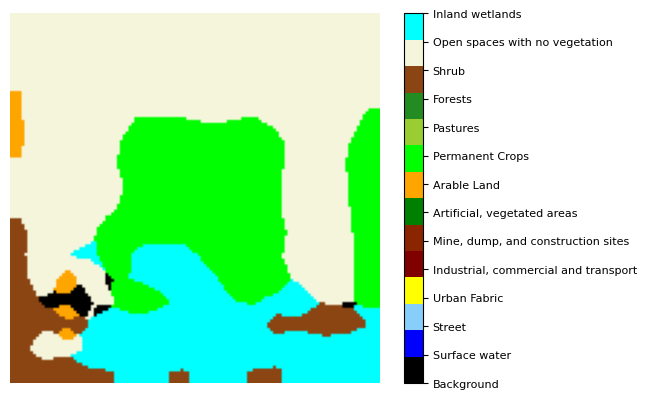

In [19]:
show_mask(segmented_image)